Classification Models for ifood-data-business-analyst-test-latam-main

By: Alejandro Rojas Benítez
https://www.linkedin.com/in/arojasb3/

this module works with the standard anaconda package except imbalanced-learn

It will need the command pip install imbalanced-learn

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from copy import deepcopy
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score
from sklearn.metrics import plot_roc_curve

from imblearn.under_sampling import RandomUnderSampler
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
df2 = pd.read_csv('data/not_scaled_data_with_clusters.csv')
df_scaled = pd.read_csv('data/scaled_data_with_clusters.csv')

In [3]:
# numerical variables we will take into account
numerical_cols = [ 'Income', 'Kidhome',
       'Teenhome', 'Recency', 'MntWines', 'MntFruits',
       'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
                 'age', 'enrollment_time', 'clusters_kmeans']

# categorical variables we will take into account. We will ignore Complain since it is too unbalanced
categorical_cols = ['Education', 'Marital_Status']

# campaigns for cluster analysis
campaings = ['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'Response']

In [4]:
random_state = 42

### Adapting the dataset
We will transfor all the categorical variables into dummies, creating new binary columns for each of their values. We will use `Education`, `Marital_Status` and `clusters_kmeans`.

This will enable an easier analysis for the influence of those variables in the model.

In [5]:
# Create a new dataset where categorical variables are dummies
X = pd.get_dummies(df_scaled[numerical_cols + categorical_cols + campaings[:-1]])

X = pd.get_dummies(X, columns=[ 'clusters_kmeans'])
X.head()

,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,...,Education_PhD,Marital_Status_Divorced,Marital_Status_Married,Marital_Status_Single,Marital_Status_Together,Marital_Status_Widow,clusters_kmeans_0,clusters_kmeans_1,clusters_kmeans_2,clusters_kmeans_3
0,0.516867,0.0,0.0,0.585859,0.425318,0.442211,0.554878,0.664093,0.444444,0.353414,...,0,0,0,1,0,0,0,0,1,0
1,0.396485,0.5,0.5,0.383838,0.007368,0.005025,0.006098,0.007722,0.005051,0.024096,...,0,0,0,1,0,0,0,0,0,1
2,0.654408,0.0,0.0,0.262626,0.285332,0.246231,0.129065,0.428571,0.106061,0.168675,...,0,0,0,0,1,0,0,0,1,0
3,0.195425,0.5,0.0,0.262626,0.007368,0.020101,0.020325,0.038610,0.015152,0.020080,...,0,0,0,0,1,0,1,0,0,0
4,0.518449,0.5,0.0,0.949495,0.115874,0.216080,0.119919,0.177606,0.136364,0.060241,...,1,0,1,0,0,0,1,0,0,0


The dataset looks good, now lets prepare our the classification, which will be the success of the last campaign `Response`.

In [6]:
y = df_scaled['Response']

Wait!
Our data is unbalanced, only 15% of the customers accepted the campaign, that makes the creation of the model a lot harder because we have a lot more samples of one class. 

To fix that issue we will undersample the dataset, basically for every 2 customers that rejected the campaign, we will have one that accepted it. Leaving a proportion of 33% instead.

In [7]:
# undersampling thanks to https://machinelearningmastery.com/random-oversampling-and-undersampling-for-imbalanced-classification/
undersample = RandomUnderSampler(sampling_strategy=0.5, random_state = random_state)

X_under, y_under= undersample.fit_resample(X, y)

In [8]:
X_under.shape, X.shape

((990, 36), (2185, 36))

In [9]:
y_under.value_counts()

0    660
1    330
Name: Response, dtype: int64

That looks a lot better, we went down from 2185 customers to only 990 but with that proportion. This will make the fitting process a lot easier.

Now lets start splitting our data, we will use the usual 60% training data, 20% validation and 20% test.

We will train our model with the training set, tune a bit some parameters with the validation and at the end check its performance with the test set.

In [10]:
# split dataset into 60% 20% 20%
X_train, X_test, y_train, y_test = train_test_split(X_under, y_under, test_size=0.2, random_state=random_state)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=random_state)

### Logistic Regression

As an initial approach we will use a logistic regression, it is a fairly simple model that enables us to see an importance of an influence of each of the variables: KISS principle.

As a parameter we will play around the C paramter from sci kit learn, which refers to the inverse regularization strength, where lower values specify stronger regularization. Our optimization criteria will be maximizing the f1 score, this choice because we want to be able to share the accuracy and recall values with the marketing deparment team, 2 easier metrics to take into a real approach compared to the AUC.

In [11]:
# logistic regression parameters set
regularization = np.linspace(0.01, 1, 100)

In [12]:
# finding best regularization for our logistic regression
prev_f1 = 0
logistic = None
best_c = 0
for C in regularization:
    clf = LogisticRegression(random_state=random_state, C = C)
    clf.fit(X_train, y_train)
    curr_f1 = f1_score(clf.predict(X_val), y_val, average='binary')
    
    if prev_f1 < curr_f1:
        prev_f1 = curr_f1
        logistic = clf
        best_c = C
C

1.0

Well, we ended up with the default C value but anyway it was a good try!


Now lets check our performance metrics for the best model we found

In [13]:
accuracy_score(logistic.predict(X_test), y_test)

0.797979797979798

In [14]:
recall_score(logistic.predict(X_test), y_test)

0.7735849056603774

In [15]:
f1_score(logistic.predict(X_test), y_test, average='binary')

0.6721311475409837

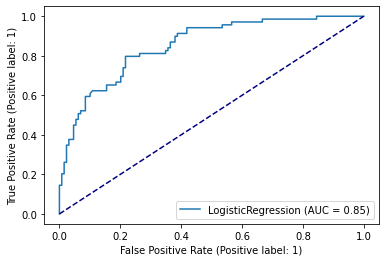

In [16]:
plot_roc_curve(logistic, X_test, y_test)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--');

That could be decent, for the moment we can be happy about our results. Now lets try to understand a bit on how the varibales affect our logistic regression.

In [17]:
models_coefficients = pd.DataFrame(logistic.coef_[0], X_train.columns, columns = ['log_coefficients'])

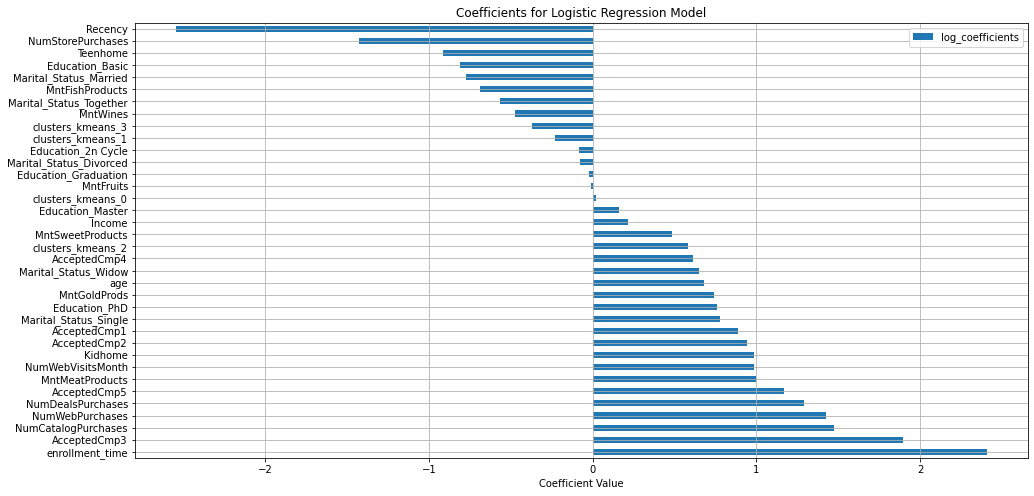

In [18]:
ax = models_coefficients.sort_values(by='log_coefficients',ascending=False).plot(kind='barh', figsize=(16,8), grid=True, title='Coefficients for Logistic Regression Model')

ax.set_xlabel('Coefficient Value');

plt.savefig('figures/log_coefficients.pdf')

Thats interesting, so recency affects the campaign in a negative way. Customers with higher recency have a much higher chance to reject the campaign. Other 2 variables that heavy influence the rejection are the number of store purchases and the number of teens at home. 

On the other hand, high enrollment times, having accepted the third campaign and the number of web purchases heavily influence the acceptance of the last campaign.

Now, looking at how our clusters obtained from the kmeans affect the model, clusters 1 and 3 tend to reject but their influence is fairly low while clusters 0 and 2 help the acceptance also with a low coefficient. It seems that the clusters we obtained before can influence the model, remembering that cluster 0 was the group that had the highest acceptance of them all.

Another interesting thing is that the customers from cluster 0 are middle of the pack on web purchases but the highest on catalog purchases which makes sense with the logistic model.

### Random Forest

Now that we got some results with the logistic regression, lets focus on another model. We will try now the random forest and then plot the importance of the variables for the best model.

In this approach we will try different number of trees and different max depths for the random forest. Again, optimizing around the f1 score. We defined the upper bound of the depth as the number of features we have in our dataset.

In [19]:
# Random Forest parameters
number_of_trees = range(100, 151)

depths = range(2, len(X.columns))

In [20]:
# finding best regularization for our logistic regression
prev_f1_rf = 0
rf = None
best_trees = 0
best_depth = 0
for trees, depth in zip(number_of_trees, depths):
    clf = RandomForestClassifier(n_estimators=trees, max_depth=depth, random_state=random_state)
    clf.fit(X_train, y_train)
    curr_f1 = f1_score(clf.predict(X_val), y_val, average='binary')
    
    if prev_f1_rf < curr_f1:
        prev_f1_rf = curr_f1
        rf = clf
        best_trees = trees
        best_depth = depth

best_trees, best_depth

(107, 9)

Ok, our best random forest model was made with 108 trees and a maximum depth of 10.

Now lets check the performance metrics.

In [21]:
accuracy_score(rf.predict(X_test), y_test)

0.7474747474747475

In [22]:
recall_score(rf.predict(X_test), y_test)

0.6557377049180327

In [23]:
f1_score(rf.predict(X_test), y_test, average='binary')

0.6153846153846154

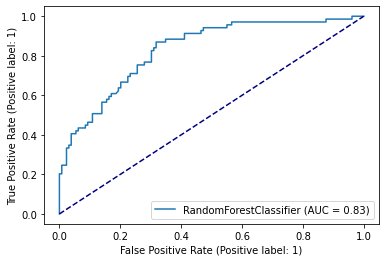

In [24]:
plot_roc_curve(rf, X_test, y_test)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--');

Well, all metrics for our test set are worse on the Random Forest than on the logistic regression, anyway they are a bit close. 
Lets check the most important variables for the campaign, maybe we can find some similarities between them both.

In [25]:
models_coefficients_rf = pd.DataFrame(rf.feature_importances_, X_train.columns, columns = ['rf_coefficients'])

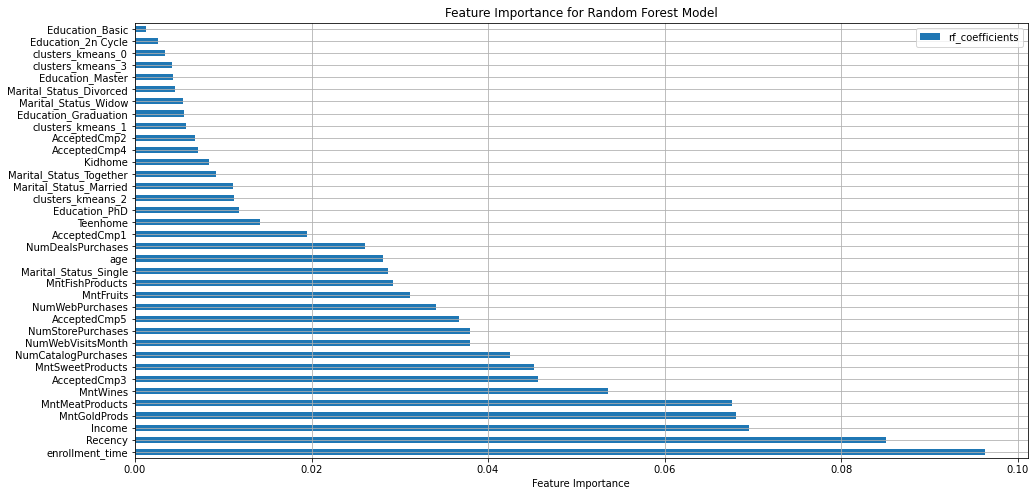

In [26]:
ax = models_coefficients_rf.sort_values(by='rf_coefficients',ascending=False).plot(kind='barh', figsize=(16,8), grid=True, title='Feature Importance for Random Forest Model')

ax.set_xlabel('Feature Importance');

Whoa! thats a lot of variables, lets plot the top 5 below

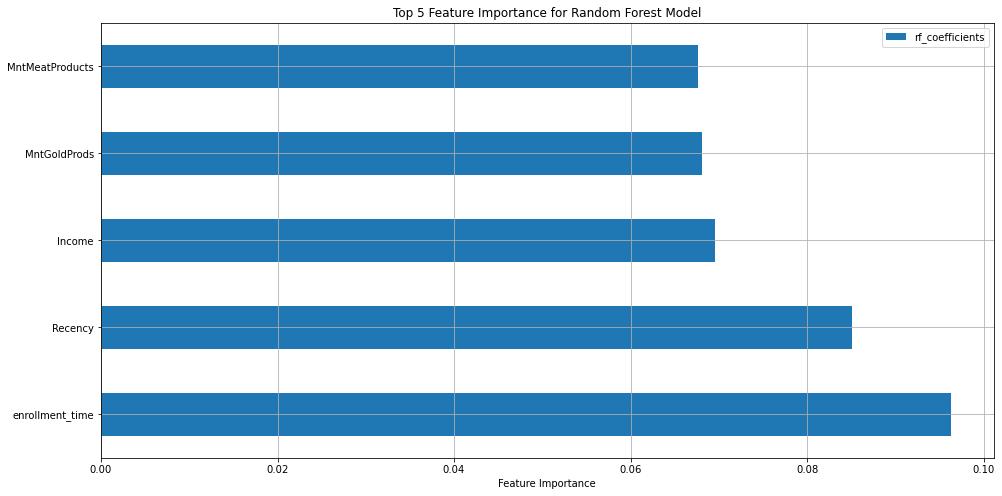

In [32]:
ax = models_coefficients_rf.nlargest(5, 'rf_coefficients').plot(kind='barh', figsize=(16,8), grid=True, title='Top 5 Feature Importance for Random Forest Model')

ax.set_xlabel('Feature Importance');

plt.savefig('figures/top5_features_rf.pdf')
plt.savefig('figures/top5_features_rf.png')

A lot better, so enrollment time and recency are 2 common variables with the logistic regression. This is cool, because those 2 doesn't help to generate the new clusters, still are super important for both classifiers. Imagine picking a customer from cluster 0 with high enrollment time and low recency, that sounds like a potential one to accept the last campaign!


This created a new question about campaign 3, what about creating the same pie chart we created before for each cluster but now for campaign 3? Lets see how they look

In [28]:
def get_campaign_frequency_cluster(df, group, campaings, k):
    """function that returns a Pandas Data Frame of the 
    percentage of accepted campaigns per cluster
    """
    kmeans_list = {}
    for camp in campaings: kmeans_list[camp] = []
    for clust in range(0, k):   
        for camp in campaings:
            kmeans_list[camp].append(1 - list(df[df[group] == clust][camp].value_counts())[0] / df[df[group] == clust].shape[0])
            
    return pd.DataFrame(kmeans_list, index=range(0, k))

def create_campaign_pie_charts(df, campaign, title):
    # thanks to help from https://stackoverflow.com/questions/62169907/seaborn-catplot-kind-count-change-bar-chart-to-pie-chart
    """function that creates a cool pie chart plot for each cluster for a campaign acceptance
    """
    fig, axes = plt.subplots(nrows=2, ncols=2)
    labels = 'Accepted', 'Rejected'
    colors = ['#008fd5', '#fc4f30']
    explode = (0.1, 0.1)

    plt.tight_layout()

    for i, col in enumerate(df.index):
        numb = df.iloc[i][campaign]
        curr = list(axes.flat)[i]
        curr.pie([numb, 1-numb], startangle=90, colors=colors, wedgeprops={'edgecolor': 'black'}, autopct='%1.f%%', explode=explode, shadow=True)
        curr.set_title(f'Cluster {i}', fontweight='bold')

    fig.suptitle(title, fontsize=20, y=1.07, fontweight='bold', x=0.37)
    fig.set_figheight(10)
    fig.set_figwidth(7)
    fig.legend(loc='best', labels=labels, fontsize='medium')
    fig.tight_layout()

In [31]:
# sucess of campaign 3 on the dataset
1 - df2['AcceptedCmp3'].value_counts()[0]/df2['AcceptedCmp3'].value_counts().sum()

0.0736842105263158

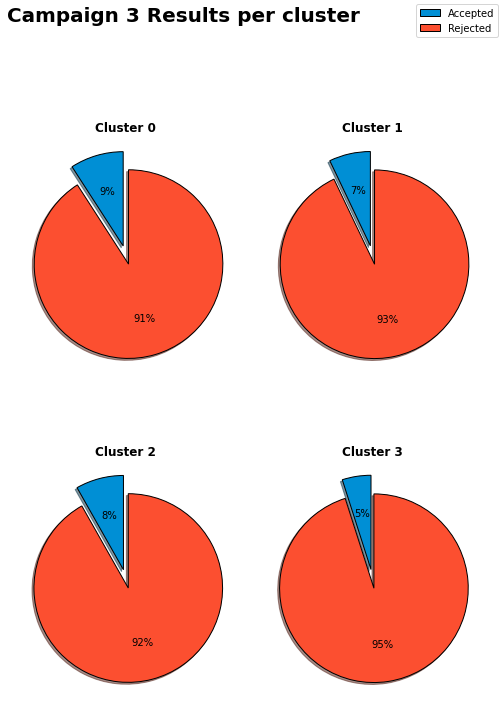

In [29]:
create_campaign_pie_charts(get_campaign_frequency_cluster(df2, 'clusters_kmeans', campaings, 4), 'AcceptedCmp3', 'Campaign 3 Results per cluster')

Oh, well not really that big of a difference compared to the last campaign. Still we know that customers that approved campaing 3 also have a higher chance of accepting the last one. This are some of the cool conclusions we can find, and why trying different techniques can be super useful on finding trends for our customers.

### Conclusions

After training this 2 classification models and already knowing some features of the cluster with the highest amount of acceptance:

- Customers with high enrollment time and low recency should be aimed for the campaign. We could call them loyal and old customers, which have been subscribed a long time and buy frequently in the store.

- Amount spent on both meat and gold seem important, but more importantly as we saw on cluster 0, we want to aim at customers with the higest income. As one can guess, the ones with the most income are also customers that can spend a lot more at the store. We would be combining here loyal customers with high income.

- Age can be somewhat important but shouldn't be the main choosing factor at the moment of deploying the campaign.

- The customers that approved campaign 3 are somewhat more likely to accept the last campaign. So checking at those old customers that bought stuff in there can be also for the marketing department to review.

- We found a group of customers (and a way to classify new ones) where the success of the last campaign was almost double compared to the overall dataset, that can be also huge for the marketing department.

- Both classifications models have an accuracy higher than 74% most probably enabling a more smart way to offer the campaign for new customers. Yes acurracy is a bit biased since we have more negative answers and thats why we also calculated the recall.

- Recall for both models is over 65%, which is not amazing but the logistic regression achieved recall over 75%. Which tells us that the model guessed correctly for 3 of every 4 customers that actually accepted the campaign.